#### Initialising seeds and importing modules required for the program

In [1]:
# Future directives
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Setting seeds : This is necessary for reproducability of the results
from numpy import random
random.seed(0)
import tensorflow as tf
tf.set_random_seed(3)
import os
os.environ['PYTHONHASHSEED'] = '2'

# Imports 
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.utils import np_utils
import os 
import scipy.misc
from tensorflow.contrib.tensorboard.plugins import projector

#Custom Scripts Imports 
import lscript as lsp
import cnn_script as cnn
import dataset as dsp

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


####  Defining parameters

In [2]:
# training parameters
flags = tf.app.flags
flags.DEFINE_float('learning_rate',0.001,'Learning rate for the optimisation algorithm')
flags.DEFINE_integer('batch_size',512,'Batch size')
flags.DEFINE_integer('epoch',10,'epochs')
val_loss=[]
val_acc=[]
usps_loss=[]
usps_acc=[]
custom_global_step=1
batch_size=flags.FLAGS.batch_size
epoch=flags.FLAGS.epoch


# Network and dataset Parameters
img_rows=16
img_cols=16
channel=1
nb_classes=10
num_input = {'rows':img_rows,'colomns':img_cols,'channel':channel} # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units
LOG_DIR='./logdir'


#### Preparing dataset

In [3]:
mnist, usps= dsp.read_datasets()

In [4]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist.train.num_images))
print("- Test-set:\t\t{}".format(mnist.test.num_images))
print("- Validation-set:\t{}".format(mnist.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps.train.num_images))
print("- Test-set:\t\t{}".format(usps.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


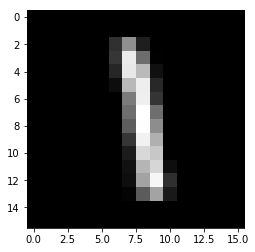

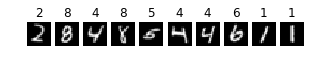

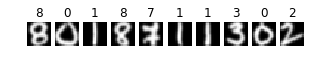

In [5]:
# Display_images
i=10
lsp.view_image(mnist.train.images[0])
lsp.view_images(mnist.train.images[i:(i+10)], mnist.train.cls[i:(i+10)])
lsp.view_images(usps.train.images[i:(i+10)], usps.train.cls[i:(i+10)])

#### Getting started with the model

In [6]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, num_input['rows'],num_input['colomns'],num_input['channel']])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [7]:
# Construct model
# Convolution Layer 1,2 and Maxpooling Layer 12
conv1 = tf.layers.conv2d(inputs=x,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
conv2 = tf.layers.conv2d(inputs=conv1,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
pool12 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    

# Convolution Layer 3,4 and Maxpooling Layer 34
conv3 = tf.layers.conv2d(inputs=pool12,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
conv4 = tf.layers.conv2d(inputs=conv3,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
pool34 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
flat = tf.reshape(pool34, [-1, 4 * 4 * 64]) 
    
dense1 = tf.layers.dense(inputs=flat, units=4 * 4 * 64, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=512, activation=tf.nn.relu)
dropout2 = tf.layers.dropout(inputs=dense2, rate=keep_prob)
    
# Logits Layer
logits = tf.layers.dense(inputs=dropout2, units=10)
    
# Reading summaries
tf.summary.histogram('logits', logits)
tf.summary.histogram('flat', flat)
tf.summary.histogram('pool12', pool12)

#logits = cnn.conv_net(x, img_rows,img_cols,keep_prob)
prediction = tf.nn.softmax(logits)

#### Defining loss, optimizer and evaluations for the model

In [8]:
# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=flags.FLAGS.learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#### Training by running a session

In [9]:
# Start a session and run variables
sess = tf.InteractiveSession()
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
sess.run(init)

# Training
iterations=int(mnist.train.num_images/batch_size)
for epoch in range(1, epoch):
    for step in range(1,iterations):
        print('.',end="")
        batch_x, batch_y=mnist.train.next_batch(batch_size)
        batch_x=lsp.reshape_grayscale_as_tensor(batch_x)
        _,_=sess.run([train_op,accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
    
    
    # Calculate epoch loss and accuracy for MNIST.valid data and USPS.train data
    test_x=lsp.reshape_grayscale_as_tensor(mnist.valid.images)
    loss_temp, acc_temp = sess.run([loss_op, accuracy], feed_dict={x: test_x, y: mnist.valid.labels,keep_prob: 1.0})
    val_loss.append(loss_temp)
    val_acc.append(acc_temp)
    loss_temp, acc_temp=sess.run([loss_op, accuracy], feed_dict={x: lsp.reshape_grayscale_as_tensor(usps.test.images), y: usps.test.labels,keep_prob: 1.0})   
    usps_loss.append(loss_temp)
    usps_acc.append(acc_temp)
    print("\nEpoch: " + str(epoch) + ", USPS Loss= " + "{:.2f}".format(loss_temp) + ", USPS Accuracy= " + "{:.2f}{}".format(acc_temp*100,'%'))
    
loss_temp, acc_temp=sess.run([loss_op, accuracy], feed_dict={x: lsp.reshape_grayscale_as_tensor(mnist.test.images), y: mnist.test.labels,keep_prob: 1.0})   
print("Optimization Finished!")

..............................................................................................
Epoch: 1, USPS Loss= 1.17, USPS Accuracy= 73.16%
..............................................................................................
Epoch: 2, USPS Loss= 1.10, USPS Accuracy= 76.44%
..............................................................................................
Epoch: 3, USPS Loss= 0.77, USPS Accuracy= 81.44%
..............................................................................................
Epoch: 4, USPS Loss= 0.50, USPS Accuracy= 87.09%
..............................................................................................
Epoch: 5, USPS Loss= 0.60, USPS Accuracy= 84.51%
..............................................................................................
Epoch: 6, USPS Loss= 0.51, USPS Accuracy= 85.42%
..............................................................................................
Epoch: 7, USPS Loss= 0.47, USPS Accuracy=

#### Plotting results & Evaluation

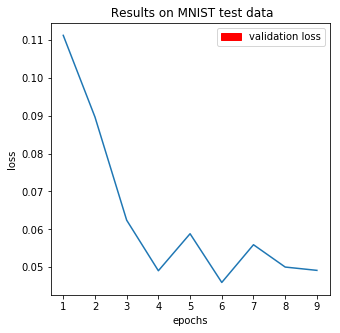

In [10]:
lsp.plot_values_with_legends(np.arange(1,len(val_loss)+1,1),val_loss,'validation loss','epochs', 'loss',' Results on MNIST test data','red')

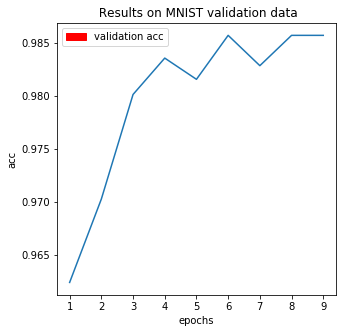

In [11]:
lsp.plot_values_with_legends(np.arange(1,len(val_acc)+1,1),val_acc,'validation acc','epochs', 'acc',' Results on MNIST validation data','red')

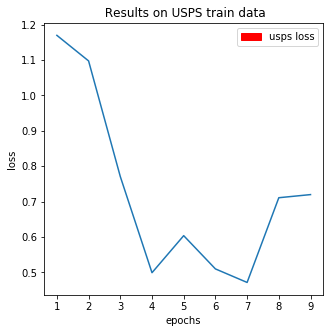

In [12]:
lsp.plot_values_with_legends(np.arange(1,len(usps_loss)+1,1),usps_loss,'usps loss','epochs', 'loss',' Results on USPS train data','red')

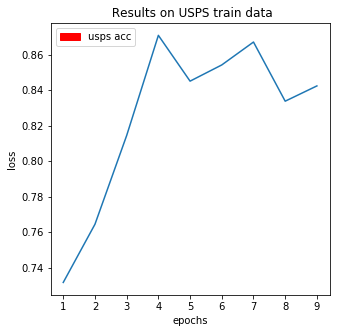

In [13]:
lsp.plot_values_with_legends(np.arange(1,len(usps_acc)+1,1),usps_acc,'usps acc','epochs', 'loss',' Results on USPS train data','red')

In [14]:
# Calculate accuracy for MNIST,USPS test images
print("Testing Accuracy on MNIST test-dataset:", \
sess.run(accuracy, feed_dict={x: lsp.reshape_grayscale_as_tensor(mnist.test.images), y: mnist.test.labels,keep_prob: 1.0}))
print("Testing Accuracy on USPS train-dataset:", \
sess.run(accuracy, feed_dict={x: lsp.reshape_grayscale_as_tensor(usps.train.images), y: usps.train.labels,keep_prob: 1.0}))
    

Testing Accuracy on MNIST test-dataset: 0.987
Testing Accuracy on USPS train-dataset: 0.834252
